<a href="https://colab.research.google.com/github/anaswara21/test/blob/main/2_Empoliticon_Context.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 3.4 MB/s eta 0:00:00


In [ ]:
import os
import re
import nltk
import sklearn
import pandas as pd
from tqdm.notebook import tqdm, trange
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from imblearn.over_sampling import SMOTEN

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import numpy as np

import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.preprocessing import LabelBinarizer

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/context_and_emotion/dataset

/content/drive/MyDrive/context_and_emotion/dataset


In [ ]:
df=pd.read_csv("Dataset_Longformer_Embedded.csv")

In [ ]:
dfFeatures = df.iloc[:, 0:768]

In [ ]:
dfTarget = df['Context']

In [ ]:
# not yet... this will be updated accordingly
nltk_data_path = os.popen('which python').read().replace('bin/python\n', '').strip() + 'nltk_data/'
nltk.download('stopwords', download_dir=nltk_data_path)

[nltk_data] Downloading package stopwords to /usr/local/nltk_data/...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train, y_test = train_test_split(dfFeatures, dfTarget, test_size=0.3,random_state=109,stratify=dfTarget)

In [ ]:
from imblearn.over_sampling import SMOTEN
sm = SMOTEN(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [ ]:
target_train=pd.DataFrame(y_res)
df_test=pd.DataFrame(X_test)
df_train=pd.DataFrame(X_res)
target_test=pd.DataFrame(y_test)
df_test['Context'] = target_test['Context']
df_train['Context'] = target_train['Context']

<ipython-input-17-fcf4bf438778>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train['Context'] = target_train['Context']


In [ ]:
context_map = {
    'DEVELOPMENT' : 0,
    'NATIONALISM' : 1,
    'EXTREMISM' : 2,
    'INTERNATIONAL' : 3,
    'OTHERS' : 4,
    0 : 'DEVELOPMENT',
    1 : 'NATIONALISM',
    2 : 'EXTREMISM',
    3 : 'INTERNATIONAL',
    4 : 'OTHERS',

}

maps = {
    'Context' : context_map,
}

In [ ]:
print(df_train['Context'].value_counts())
print(df_test['Context'].value_counts())

Context
INTERNATIONAL AFFAIRS    525
DEVELOPMENT              525
OTHERS                   525
NATIONALISM              525
EXTREMISM                525
Name: count, dtype: int64
Context
DEVELOPMENT              225
OTHERS                   162
INTERNATIONAL AFFAIRS    155
NATIONALISM               42
EXTREMISM                 19
Name: count, dtype: int64


In [ ]:
maps["Context"]["INTERNATIONAL AFFAIRS"] = len(maps["Context"])

In [ ]:
df_train['Context'] = df_train['Context'].apply(lambda x : maps["Context"][x])
df_test['Context'] = df_test['Context'].apply(lambda x : maps["Context"][x])

In [ ]:
class_names=["DEVELOPMENT","NATIONALISM","EXTREMISM","INTERNATIONAL AFFAIRS", "OTHERS"]

In [ ]:

label_binarizer = LabelBinarizer().fit(df_train['Context'])
y_onehot_test = label_binarizer.transform(df_test['Context'])
y_onehot_test.shape  # (n_samples, n_classes)

(603, 5)

In [ ]:
model2 = CatBoostClassifier(n_estimators=1550,
                        learning_rate=0.1,
                        depth=5, task_type='CPU',
                        random_state=1,
                        verbose=False)

model5 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
model6 = svm.NuSVC(decision_function_shape='ovr',break_ties=True,probability=True)

In [ ]:
model = VotingClassifier(estimators=[('nusvc',model6 ), ('cat', model2), ('lin', model5)], voting='soft')

In [ ]:
model.fit(df_train.iloc[:, 0:768], df_train['Context'])

VotingClassifier(estimators=[('nusvc',
                              NuSVC(break_ties=True, probability=True)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7c54aee40100>),
                             ('lin',
                              LinearDiscriminantAnalysis(shrinkage='auto',
                                                         solver='lsqr'))],
                 voting='soft')

In [ ]:
model.score(df_test.iloc[:, 0:768], df_test['Context'])

0.714759535655058

In [ ]:
y_pred=model.predict(df_test.iloc[:, 0:768])

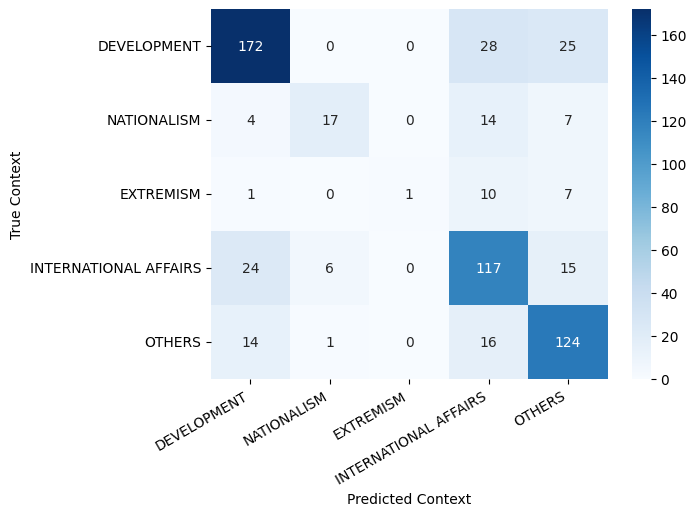

In [ ]:

def show_confusion_matrix(confusion_matrix):
   hmap= sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
   hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
   hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
   plt.ylabel('True Context')
   plt.xlabel('Predicted Context');

cm = confusion_matrix(df_test['Context'], y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:

print(metrics.classification_report(df_test['Context'], y_pred))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       225
           1       0.71      0.40      0.52        42
           2       1.00      0.05      0.10        19
           4       0.63      0.72      0.67       162
          10       0.70      0.80      0.74       155

    accuracy                           0.71       603
   macro avg       0.77      0.55      0.56       603
weighted avg       0.73      0.71      0.70       603



In [ ]:
y_score_proba = model.predict_proba(df_test.iloc[:, 0:768])

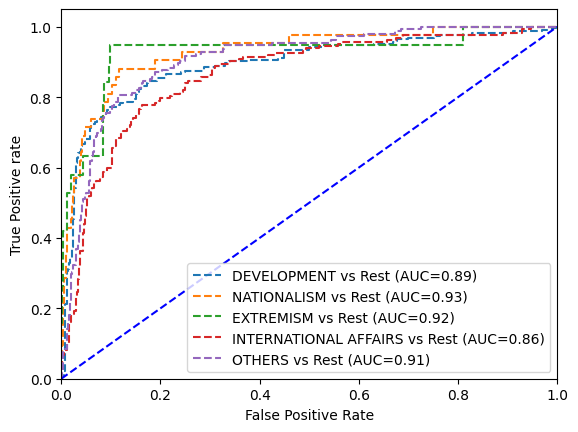

In [ ]:
# actual_labels_binarized = label_binarize(actual_labels, classes=category_list)
category_list = ["DEVELOPMENT","NATIONALISM","EXTREMISM","INTERNATIONAL AFFAIRS", "OTHERS"]
fpr = {} # False Positive Rate
tpr = {} # True Positive Rate
thresh ={} # Threshold
roc_auc = dict()

# plt.figure(figsize = (10, 7))
for i in range(5):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_onehot_test[:, i], y_score_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    plt.plot(fpr[i], tpr[i], linestyle='--',
             label='%s vs Rest (AUC=%0.2f)'%(category_list[i],roc_auc[i]))


plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
# plt.title('Multiclass ROC curve of Linear Discriminant Analysis')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()